In [ ]:
from tfilterspy.state_estimation.linear_filters import DaskKalmanFilter
from tfilterspy.state_estimation.nonlinear_filters import DaskNonLinearKalmanFilter
from tfilterspy.state_estimation.particle_filters import DaskParticleFilter

ModuleNotFoundError: No module named 'tfilterspy'

_______

# ComputerVision 
- Image Denoising
____

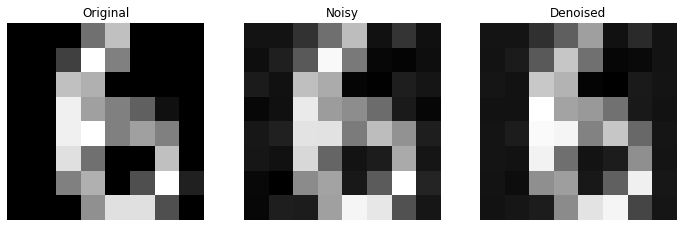

Accuracy after denoising: 0.9417
True label: 6, Predicted: 6


C:\Users\thabanglukhetho\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [5]:
import numpy as np
import dask.array as da
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

# Assuming your DaskKalmanFilter is defined as provided earlier
# Replace with your actual imports if needed
# from TFilterPy.kalman_filter import DaskKalmanFilter

# Load and split the digits dataset (limited to 50 samples as in your code)
digits = load_digits()
x = digits.data[0:2000]  # (50, 64)
y = digits.target[0:2000]  # (50,)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Convert to Dask arrays (adjust chunks for smaller dataset)
x_train_dask = da.from_array(x_train, chunks=(10, 64))  # 40 samples, ~4 chunks
x_test_dask = da.from_array(x_test, chunks=(10, 64))    # 10 samples, ~1 chunk
y_train_dask = da.from_array(y_train, chunks=(10,))
y_test_dask = da.from_array(y_test, chunks=(10,))

# Add synthetic noise to the data
noise_level = 0.88  # Adjust this to control noise intensity
noisy_x_train_dask = x_train_dask + da.random.normal(0, noise_level, x_train_dask.shape, chunks=x_train_dask.chunks)
noisy_x_test_dask = x_test_dask + da.random.normal(0, noise_level, x_test_dask.shape, chunks=x_test_dask.chunks)

# Define Kalman Filter parameters
n_features = 64
n_observations = 64
F = np.eye(n_features)  # Static state transition
H = np.eye(n_observations)  # Direct observation
Q = np.eye(n_features) * 0.01  # Initial process noise
R = np.eye(n_observations) * 0.1  # Initial observation noise
x0 = np.zeros(n_features)  # Initial state
P0 = np.eye(n_features) * 1.0  # Initial covariance

# Initialize the DaskKalmanFilter
kf = DaskKalmanFilter(
    state_transition_matrix=F,
    observation_matrix=H,
    process_noise_cov=Q,
    observation_noise_cov=R,
    initial_state=x0,
    initial_covariance=P0,
    estimation_strategy="mle"
)

# Fit and estimate parameters on noisy training data
kf.fit(noisy_x_train_dask)
Q_est, R_est = kf.estimate_parameters(noisy_x_train_dask)
kf.Q, kf.R = Q_est, R_est  # Update with estimated parameters

# Denoise the data
train_states = kf.predict().compute()  # Denoised training states
kf.fit(noisy_x_test_dask)  # Refit on test data
test_states = kf.predict().compute()  # Denoised test states

# Visualize before (noisy) and after (denoised) for a test sample
sample_idx = 0
noisy_image = noisy_x_test_dask[sample_idx].compute().reshape(8, 8)
denoised_image = test_states[sample_idx].reshape(8, 8)
original_image = x_test[sample_idx].reshape(8, 8)  # For reference

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title("Original")
axes[1].imshow(noisy_image, cmap='gray')
axes[1].set_title("Noisy")
axes[2].imshow(denoised_image, cmap='gray')
axes[2].set_title("Denoised")
for ax in axes:
    ax.axis('off')
plt.show()

# Optional: Classify denoised states and check accuracy
clf = LogisticRegression(max_iter=1000)
clf.fit(train_states, y_train)
y_pred = clf.predict(test_states)
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy after denoising: {accuracy:.4f}")

# Show prediction for the visualized sample
print(f"True label: {y_test[sample_idx]}, Predicted: {y_pred[sample_idx]}")

# Multi-variate Time Series

Mean Squared Error: 3101511.7612


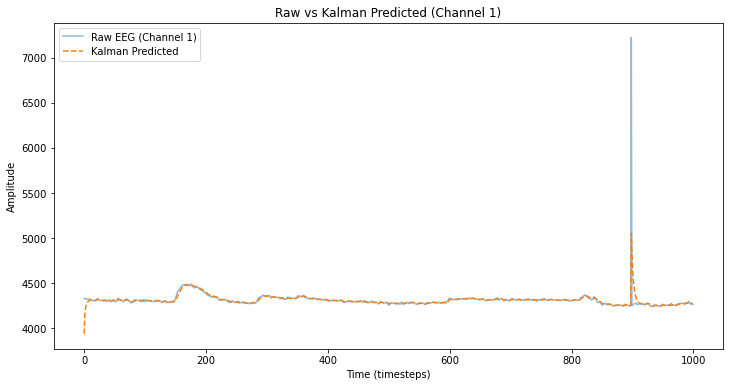

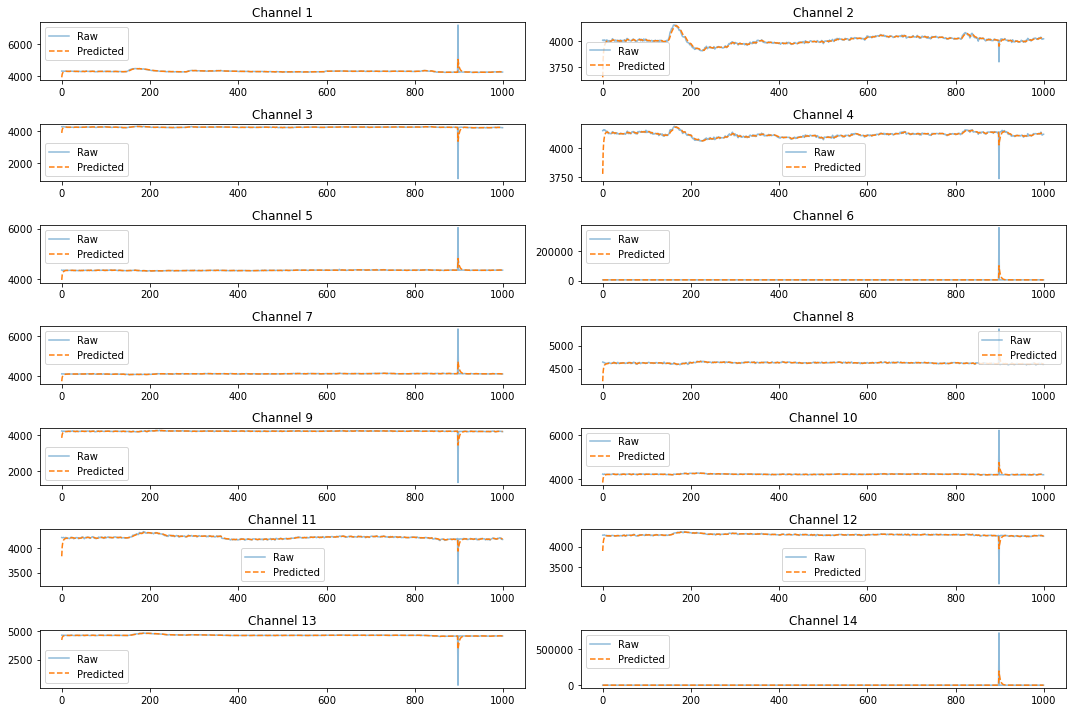

In [6]:
# from your_module import DaskKalmanFilter  # Adjust import path
from sklearn.datasets import fetch_openml
import dask.array as da
import numpy as np
import matplotlib.pyplot as plt

# Load data
data = fetch_openml(name='eeg-eye-state', version=1, as_frame=False)
X = data.data[0:9000,:]  # Shape: (14980, 14)
X_dask = da.from_array(X, chunks=(1000, 14))

# Kalman Filter setup
n_features = 14
F = np.eye(n_features)  # Static transition (identity for simplicity)
H = np.eye(n_features)  # Direct observation
Q = np.eye(n_features) * 0.01  # Process noise
R = np.eye(n_features) * 0.1   # Observation noise
x0 = np.zeros(n_features)      # Initial state
P0 = np.eye(n_features)        # Initial covariance
kf = DaskKalmanFilter(F, H, Q, R, x0, P0, estimation_strategy="residual_analysis")

# Fit and predict
kf.fit(X_dask)
predicted_states = kf.predict().compute()  # Shape: (14980, 14)

# Compute MSE
mse = np.mean((X - predicted_states) ** 2)
print(f"Mean Squared Error: {mse:.4f}")

# Plot raw vs predicted for a subset (first 1000 timesteps, first channel)
subset_size = 1000
channel = 0  # Channel 1 (index 0)
plt.figure(figsize=(12, 6))
plt.plot(X[:subset_size, channel], label='Raw EEG (Channel 1)', alpha=0.5)
plt.plot(predicted_states[:subset_size, channel], label='Kalman Predicted', linestyle='--')
plt.title('Raw vs Kalman Predicted (Channel 1)')
plt.xlabel('Time (timesteps)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Optional: Plot all channels (first 1000 timesteps)
plt.figure(figsize=(15, 10))
for i in range(14):
    plt.subplot(7, 2, i + 1)
    plt.plot(X[:subset_size, i], label='Raw', alpha=0.5)
    plt.plot(predicted_states[:subset_size, i], label='Predicted', linestyle='--')
    plt.title(f'Channel {i+1}')
    plt.legend()
plt.tight_layout()
plt.show()

In [7]:
path_to_disaster_tweets= r'C:\Users\thabanglukhetho\Documents\gits\tfilterPy\examples\data\train_nlp.csv'

import pandas as pd
import numpy as np
import dask.array as da
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
# from your_module import DaskKalmanFilter  # Adjust import
import matplotlib.pyplot as plt

# 1. Load Disaster Tweets
data_path = path_to_disaster_tweets  # Update after download
df = pd.read_csv(data_path)
tweets = df['text'].values[0:5000]  # ~7613 tweets
print(f"Number of tweets: {len(tweets)}")

# 2. Preprocess and Extract Topics
vectorizer = CountVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(tweets)
n_topics = 5  # e.g., disaster, weather, casual, news, other
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
topic_dist = lda.fit_transform(X)  # Shape: (7613, 5)
X_dask = da.from_array(topic_dist, chunks=(1000, n_topics))
print(f"Topic distribution shape: {X_dask.shape}")

# Kalman Filter setup
# n_features = 14
# F = np.eye(n_features)  # Static transition (identity for simplicity)
# H = np.eye(n_features)  # Direct observation
# Q = np.eye(n_features) * 0.01  # Process noise
# R = np.eye(n_features) * 0.1   # Observation noise
# x0 = np.zeros(n_features)      # Initial state
# P0 = np.eye(n_features)        # Initial covariance
# kf = DaskKalmanFilter(F, H, Q, R, x0, P0, estimation_strategy="residual_analysis")


Number of tweets: 5000
Topic distribution shape: (5000, 5)


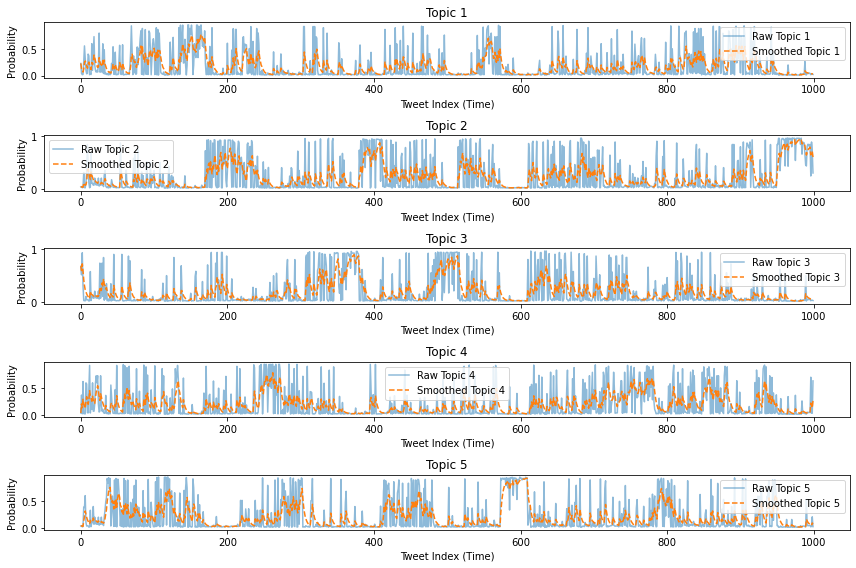

Topic 1: man, accident, just, https, http
Topic 2: û_, video, gt, body, http
Topic 3: best, û_, like, amp, http
Topic 4: emergency, amp, don, https, http
Topic 5: years, hiroshima, new, û_, http


In [8]:
# Kalman Filter setup
F = np.eye(n_topics)  # Static transition (identity for simplicity)
H = np.eye(n_topics)  # Direct observation
Q = np.eye(n_topics) * 0.01  # Process noise
R = np.eye(n_topics) * 0.1   # Observation noise
x0 = topic_dist[0]      # Initial state
P0 = np.eye(n_topics)        # Initial covariance
kf = DaskKalmanFilter(F, H, Q, R, x0, P0, estimation_strategy="residual_analysis")


kf.fit(X_dask)
smoothed_topics = kf.predict().compute()

# 4. Plot Raw vs Smoothed Topics (first 1000 tweets)
subset_size = 1000
plt.figure(figsize=(12, 8))
for i in range(n_topics):
    plt.subplot(n_topics, 1, i + 1)
    plt.plot(topic_dist[:subset_size, i], label=f"Raw Topic {i+1}", alpha=0.5)
    plt.plot(smoothed_topics[:subset_size, i], label=f"Smoothed Topic {i+1}", linestyle="--")
    plt.title(f"Topic {i+1}")
    plt.xlabel("Tweet Index (Time)")
    plt.ylabel("Probability")
    plt.legend()
plt.tight_layout()
plt.show()

# 5. Interpret Topics (optional)
feature_names = vectorizer.get_feature_names_out()
for i, topic in enumerate(lda.components_):
    top_words = [feature_names[j] for j in topic.argsort()[-5:]]
    print(f"Topic {i+1}: {', '.join(top_words)}")
